In [5]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]
from HeaderP import *

In [3]:
simsnames

['6.96e11', '8.26e11', '7.08e11', '1.12e12', '2.79e12', '7.55e11']

In [6]:
i=4
data=pd.read_pickle('./g'+simsnames[i]+'_z_0_decomp.pkl')



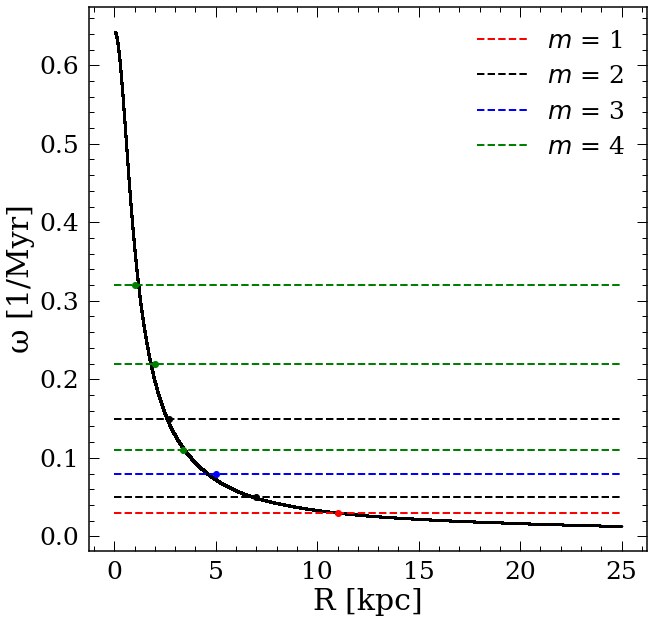

In [47]:
plt.plot(data['R'], (data['vc'].values*u.km/u.s).to(u.kpc/u.Myr)/data['R'], 'k.', markersize=1)
plt.xlabel('R [kpc]')
plt.ylabel('ω [1/Myr]')

plt.plot([0, 25], [0.03, 0.03], 'r--', label='$m$ = 1')
plt.plot([11], [0.03], 'ro')
plt.plot([0, 25], [0.15, 0.15], 'k--', label='$m$ = 2')
plt.plot([2.7], [0.15], 'ko')
plt.plot([0, 25], [0.05, 0.05], 'k--')
plt.plot([7],[0.05],'ko')
plt.plot([0, 25], [0.08, 0.08], 'b--', label='$m$ = 3')
plt.plot([5],[0.08],'bo')
plt.plot([0, 25], [0.32, 0.32], 'g--', label='$m$ = 4')
plt.plot([1],[0.32],'go')
plt.plot([0, 25], [0.11, 0.11], 'g--')
plt.plot([3.4],[0.11],'go')
plt.plot([0, 25], [0.22, 0.22], 'g--')
plt.plot([2],[0.22],'go')

plt.legend()

In [9]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob

In [10]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [11]:
def calcRbir_cv(data, fold=5):
    fold = int(fold)

    args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    for a, b in combinations_with_replacement(args, 2):
        X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
        Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [12]:
cols = ['iord','r','z','x','y']
def calc_bar_angle(data, rbar=3.5, drbar=0.5, plotfig=False):
    rbar=3
    drbar=0.1
    dub=3
    
    data['R'], data['phi'] = cart2pol(data['x'], data['y'])
    data_r = data.loc[abs(data['R']-rbar)<drbar].reset_index(drop=True)
    dens = np.histogram(data_r['phi'],bins=np.linspace(-np.pi,np.pi,360), density=True);

    ### FFT
    degs = (dens[1][:-1]+dens[1][1:])/2
    dens_p = dens[0]

    N = len(dens_p)
    Ts = (max(degs)-min(degs))/N
    yf = np.fft.fft(dens_p-np.mean(dens_p))

    Y = 2./N*abs(yf[0:N//2])
    
    barangle=-np.angle(yf[2])/2.

    if plotfig:
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(dens[1][:-1], dens[0], 'k-')
        plt.subplot(1,2,2)
        plt.plot(Y ,'k-o')
    return barangle, 2./N*abs(yf[2])

def generatepkl(simname):
    print(simname)
    allsnaps = glob.glob(simname+'/*.?????')
    
    agepickle = readsimdata(simname.split('_')[0][1:],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    allages_rs = np.zeros(len(sortage))
        
    for j in trange(len(allages_rs)):
        if os.path.exists(snaplookup[sortage[j]]+'.pkl'):
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            try:
                this_snap['x']
            except:
                s = pb.load(snaplookup[sortage[j]])
                h=s.halos()
                try:
                    pb.analysis.angmom.faceon(h[1])
                except:
                    print('no halo!')
                    continue
                s.physical_units()
                sim = h[1]

                stars = sim.s
                if len(stars)==0:
                    print('no stars!')
                    continue

                try:
                    stars['iord']
                except:
                    print('no IDs!')
                    continue
                this_snap = pd.DataFrame({k:stars[k] for k in cols})

                this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
                this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        else:
            s = pb.load(snaplookup[sortage[j]])
            h=s.halos()
            try:
                pb.analysis.angmom.faceon(h[1])
            except:
                print('no halo!')
                continue
            s.physical_units()
            sim = h[1]

            stars = sim.s
            if len(stars)==0:
                print('no stars!')
                continue

            try:
                stars['iord']
            except:
                print('no IDs!')
                continue
            this_snap = pd.DataFrame({k:stars[k] for k in cols})

            this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
            this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        

def calc_bar_speed(simname, rbar=3.5, drbar=0.5):
    print(simname)
    allsnaps = glob.glob(simname+'/*.?????')
    
    agepickle = readsimdata(simname.split('_')[0][1:],True, 15, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    allages_rs = np.zeros(len(sortage))
    
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
        
    barspeeds = np.zeros(len(allages_rs)-1)
    amps = np.zeros(len(allages_rs)-1)
    
    
    for j in trange(len(allages_rs)-1):
        try:
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            next_snap = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
        except:
            print("can't read in snaps!")
            continue
        #print(snaplookup[sortage[j]], snaplookup[sortage[j+1]])
        barangle1, amp1 = calc_bar_angle(this_snap, rbar=rbar, drbar=drbar)
        barangle2, amp2 = calc_bar_angle(next_snap, rbar=rbar, drbar=drbar)
        if barangle2-barangle1<0:
            barangle2 = barangle2+np.pi
        #print(barangle1, barangle2)
        barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
        amps[j] = amp2
    return (allages_rs[:-1]+allages_rs[1:])/2, barspeeds, amps
    
    

In [13]:
cosmictime, patternspeed, amps, sim_bar = [], [], [], []
for i in range(len(sims)):
    if sims[i]=='g1.12e12_3x9':
        continue
    else:
        #print('Generating pickle files:')
        #generatepkl(sims[i])
        #print('Calculating Ωb:')
        cosmictime_s, patternspeed_s, amps_s = calc_bar_speed(sims[i], rbar=3, drbar=0.5)
        patternspeed_s = np.array(((patternspeed_s)/u.Gyr).to(u.km/u.s/u.kpc).value, dtype=float)
        sim_bar.append(sims[i])
        cosmictime.append(np.array(cosmictime_s, dtype=float))
        patternspeed.append(patternspeed_s)
        amps.append(np.array(amps_s, dtype=float))


g6.96e11_3x9


  0%|          | 0/127 [00:00<?, ?it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  3%|▎         | 4/127 [00:00<00:03, 34.41it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


can't read in snaps!


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
 12%|█▏        | 15/127 [00:00<00:02, 47.92it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
100%|██████████| 127/127 [00:18<00:00,  7.02it/s]


g8.26e11_2x4x8


  0%|          | 0/179 [00:00<?, ?it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  4%|▍         | 7/179 [00:00<00:02, 67.20it/s]

can't read in snaps!
can't read in snaps!


 19%|█▉        | 34/179 [00:01<00:05, 25.48it/s]

can't read in snaps!
can't read in snaps!


 69%|██████▉   | 124/179 [00:51<00:39,  1.41it/s]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 71%|███████   | 127/179 [00:54<00:38,  1.35it/s]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 73%|███████▎  | 131/179 [01:01<01:30,  1.89s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 75%|███████▍  | 134/179 [01:05<01:01,  1.37s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 77%|███████▋  | 137/179 [01:12<01:23,  2.00s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide

g7.08e11_5x10


  0%|          | 0/159 [00:00<?, ?it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: R

can't read in snaps!


100%|██████████| 159/159 [02:17<00:00,  1.16it/s]


g2.79e12_3x6


  0%|          | 0/228 [00:00<?, ?it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: R

can't read in snaps!
can't read in snaps!
can't read in snaps!


 15%|█▌        | 35/228 [00:01<00:06, 28.23it/s]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 75%|███████▌  | 172/228 [03:50<04:40,  5.01s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 77%|███████▋  | 175/228 [04:05<03:56,  4.46s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 79%|███████▊  | 179/228 [04:23<04:25,  5.42s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  barspeeds[j] = (barangle2-barangle1)/(allages_rs[j+1]-allages_rs[j])
 80%|███████▉  | 182/228 [04:29<02:21,  3.08s/it]/tmp/ipykernel_3512465/175068876.py:135: RuntimeWarning: divide 

g7.55e11_3x9


  0%|          | 0/127 [00:00<?, ?it/s]/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  7%|▋         | 9/127 [00:00<00:01, 86.01it/s]

can't read in snaps!


100%|██████████| 127/127 [00:45<00:00,  2.78it/s]


In [15]:
#sim_bar = np.load('sim_bar.npy')
#cosmictime = np.load('cosmictime.npy')
#patternspeed = np.load('patternspeed.npy')
#amps = np.load('amps.npy')

In [14]:
np.save('sim_bar',sim_bar)
np.save('cosmictime',cosmictime)
np.save('patternspeed',patternspeed)
np.save('amps',amps)

/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


plotting cosmic times
g6.96e11_3x9 0.02279401670499593


/tmp/ipykernel_3512465/2297485095.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


g8.26e11_2x4x8 0.012171388618551002


/tmp/ipykernel_3512465/2297485095.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


g7.08e11_5x10 0.016795018960490203


/tmp/ipykernel_3512465/2297485095.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


g2.79e12_3x6 0.04611144765042728


/tmp/ipykernel_3512465/2297485095.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


g7.55e11_3x9 0.0165365810085131


/tmp/ipykernel_3512465/2297485095.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,1])


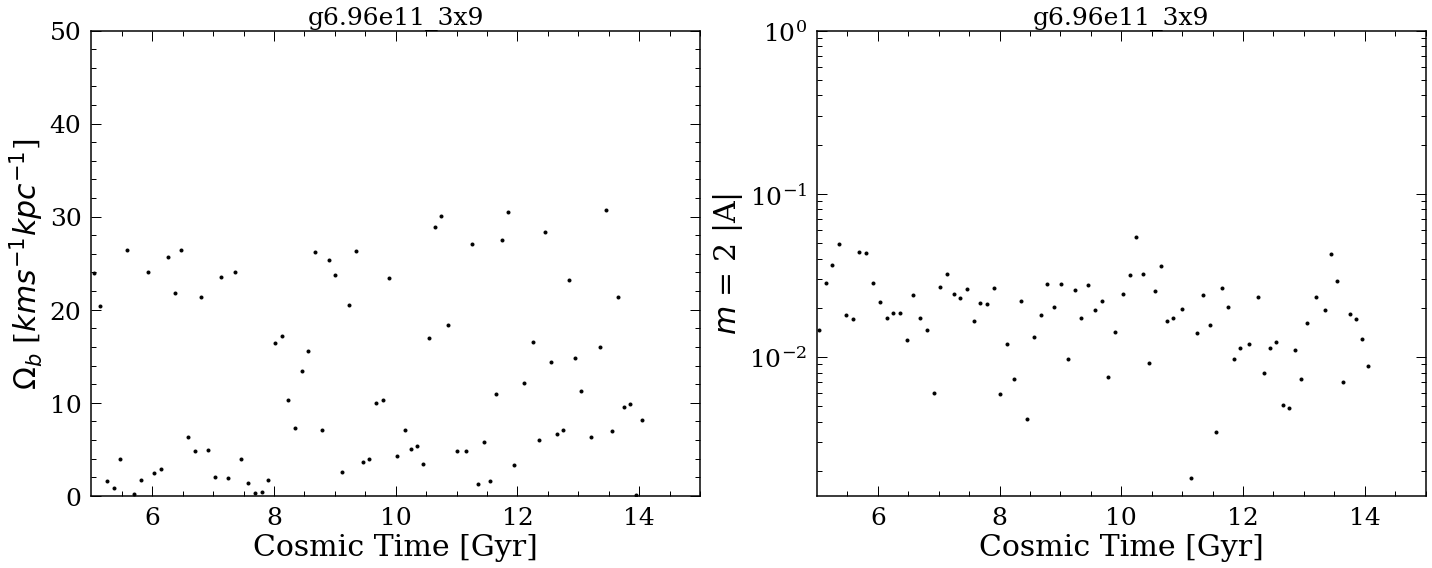

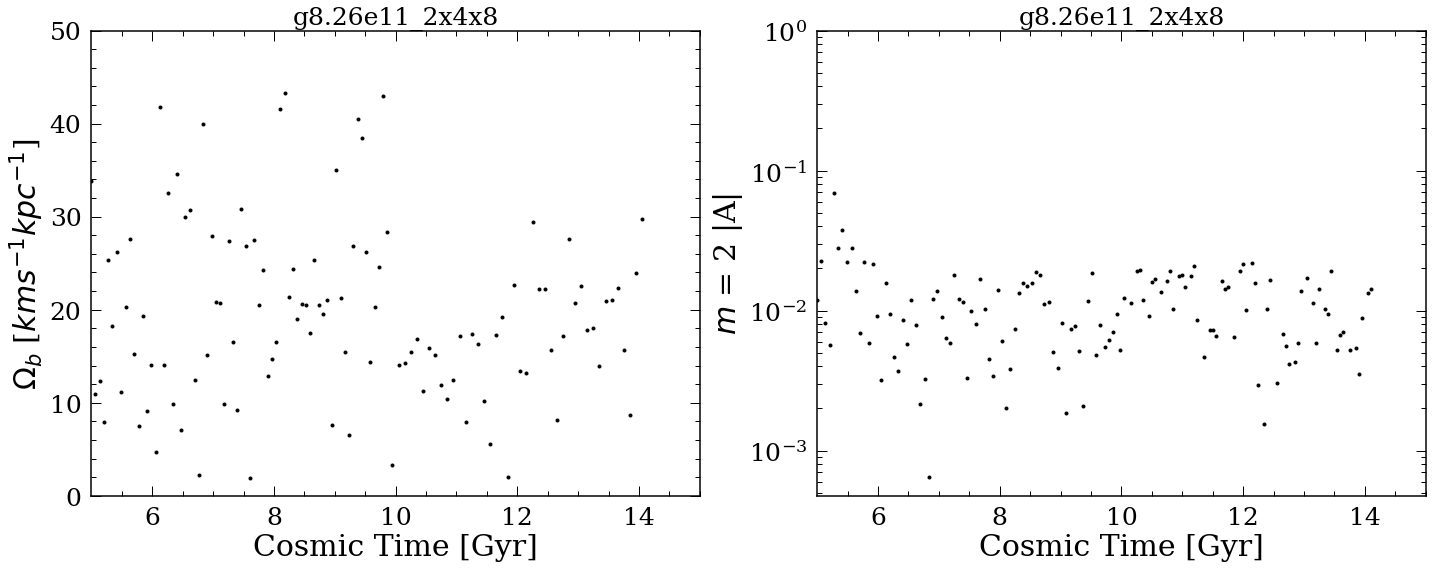

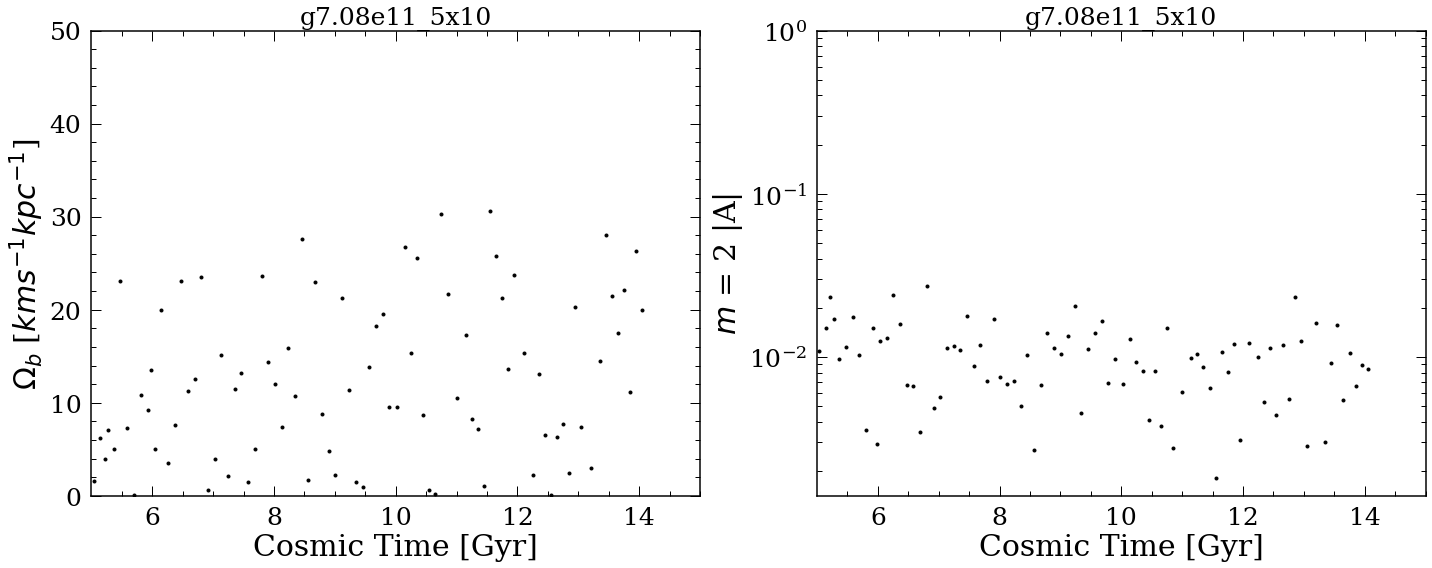

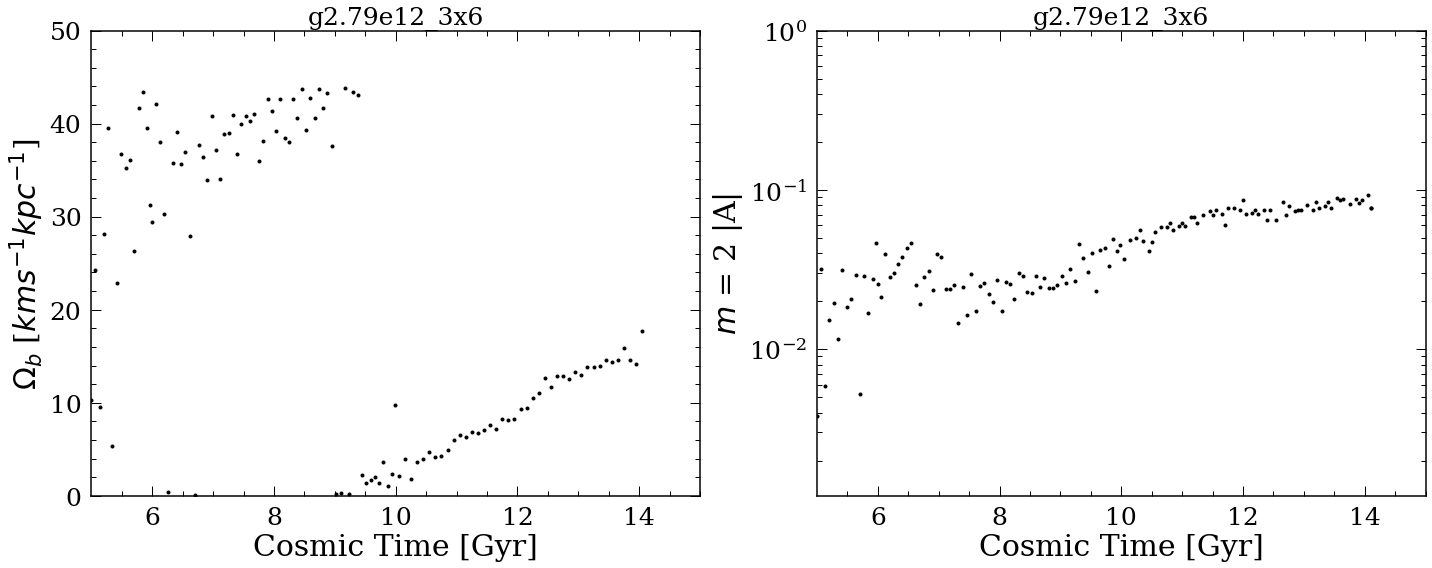

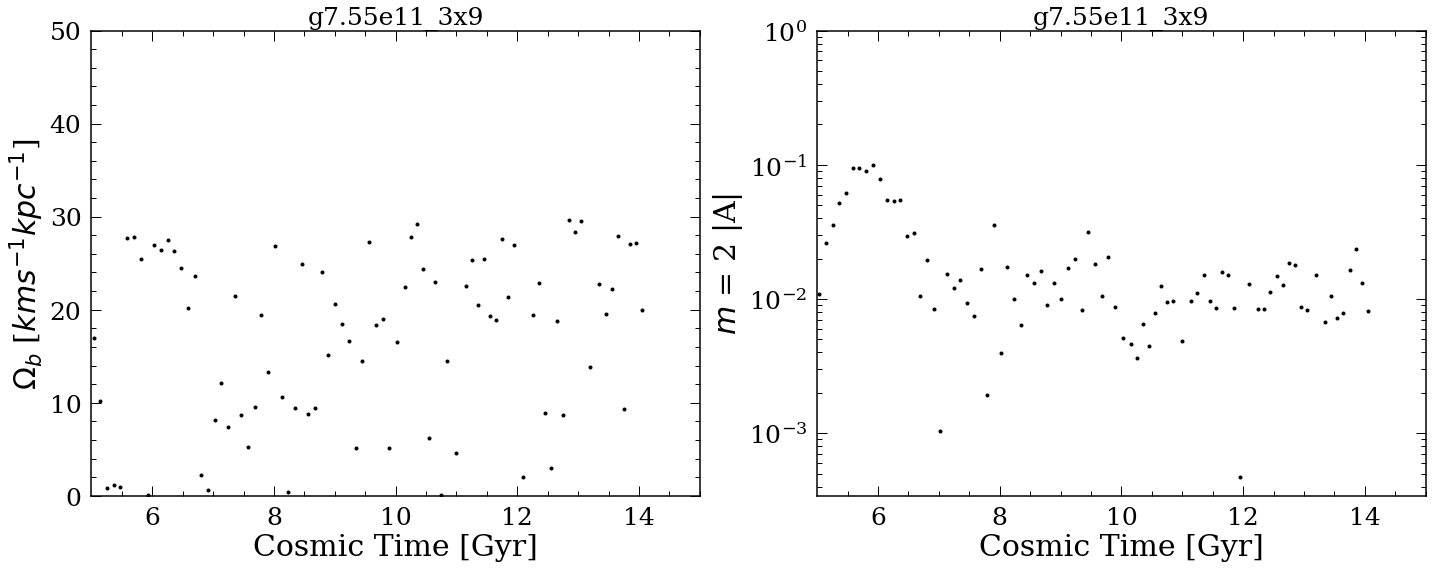

In [20]:

print('plotting cosmic times')
for i in range(5):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.plot(cosmictime[i], patternspeed[i], 'k.')
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('$Ω_{b}$ [$km s^{-1} kpc^{-1}$]')
    plt.ylim([0,50])
    plt.xlim([5,15])
    plt.title(sim_bar[i],fontsize=25)
    
    plt.subplot(1,2,2)
    plt.semilogy(cosmictime[i], amps[i], 'k.')
    print(sim_bar[i], np.median(pd.Series(amps[i]).dropna()))
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('$m$ = 2 |A|')
    plt.ylim([0,1])
    plt.xlim([5,15])
    plt.title(sim_bar[i],fontsize=25)
    plt.tight_layout()

In [43]:
(10*u.km/u.s/u.kpc).to(1/u.Myr)*200

<Quantity 2.04542433 1 / Myr>

Check if code works

In [ ]:
simname=sims[i]
allsnaps = glob.glob(simname+'/*.?????')
    
agepickle = readsimdata(simname.split('_')[0][1:],True, 15, 5)

allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

sortage = sorted(allsnaps_time)
allages_rs = np.zeros(len(sortage))

for j in trange(len(sortage)):
    s = pb.load(snaplookup[sortage[j]])
    h = s.properties['h']
    ages = float(str(s.properties['time']).split(' ')[0])
    allages_rs[j] = ages

barspeeds = np.zeros(len(allages_rs)-1)
amps = np.zeros(len(allages_rs)-1)

In [ ]:
rbar = 3
drbar = 0.2
j=int(len(allages_rs)/2)
this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
next_snap = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')

barangle1, amp1 = calc_bar_angle(this_snap, rbar=rbar, drbar=drbar, plotfig=True)


In [ ]:
barangle2, amp2 = calc_bar_angle(next_snap, rbar=rbar, drbar=drbar, plotfig=True)
    

In [ ]:
calc_bar_speed(sims[i], rbar=3.5, drbar=0.5)

In [ ]:
pd.DataFrame({k:out[k] for k in cols})